# Boilerplate

In [1]:
# python internal 
import collections
import copy
import gc
from glob import glob
import h5py
import itertools
import os
print(os.getcwd())
import random
import re
import socket
print(socket.gethostname())
import shutil
import subprocess
import sys
# conda/pip
import dask
import graphviz
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm
# special packages on the DIGS
import py3Dmol
import pymol
import pyrosetta
# notebook magic
%matplotlib inline
%load_ext autoreload
%autoreload 2

/mnt/home/pleung/projects/bistable_bundle/r3/hinges
dig105


# Flo's original approach:
7. Two-state design: 
`/home/flop/switch/5thround/DHRs/msd7/msd_scripts/` has the scripts



# I need to add a few things to Flo's method.
I will use the serialization build of PyRosetta to enable recording user defined info about the designs.  
This enables downstream inline filtering and data analysis, as well as clustering by lineage.

TODO sequence recovery of parent as a final metric in 05?  
TODO explore `FavorSequenceProfile` instead of `FavorNativeResidue`

# Make functions for looping and labeling to assist downstream penultimate design step

In [12]:
from pyrosetta.distributed.packed_pose.core import PackedPose

from typing import *

def msd(pickle_str:str, **kwargs) -> Generator[str, PackedPose, None]:
    """
    TODO assumes middle split
    TODO ala and np penalties, SAP
    TODO only 2G mem? 3G...
    """
    
    import binascii
    import bz2
    from copy import deepcopy
    import os
    import pickle
    import pyrosetta
    from pyrosetta.rosetta.core.pose import Pose
    import pyrosetta.distributed.io as io
    
    # TODO TODO TODO this is checking if conda can be seen on the workers
    import shutil
    print(shutil.which("conda"))
    
    
    if pickle_str == None:
        pickle_str = kwargs["pickle_path"]
    else:
        pass
    
    with open(pickle_str, "rb") as handle:
        state_dict = pickle.load(handle)
    state_X_dict, state_Y_dict = state_dict["state_X_dict"], state_dict["state_Y_dict"]
    
    poses = []
    # load and set scores of poses for states X and Y
    for state in state_X_dict, state_Y_dict:
        assert len(state) == 1
        (path, scores), = state.items()
        with open(path, "rb") as f:
            filename = str(binascii.b2a_hex(os.urandom(16)).decode("utf-8")) + ".pdb.temp"
            with open(filename, "w+") as g:
                print(bz2.decompress(f.read()).decode(), file=g)
            ppose = io.pose_from_file(filename)
            os.remove(filename)
            pose = io.to_pose(ppose)
            for key, value in scores.items():
                pyrosetta.rosetta.core.pose.setPoseExtraScore(pose, key, value)
        poses.append(pose)
    
    state_X, state_Y = poses[0], poses[1]
    
    ala_penalty = 1
    if kwargs["np_penalty_"] == None:
        np_penalty = 3
    else:
        np_penalty = kwargs["np_penalty_"]
    og_np_penalty = deepcopy(np_penalty) # TODO this might be bad
    scores = deepcopy(state_Y.scores)
    sfxn_used = scores["sfxn_used"]
    parent_sequence = state_X.sequence()

    # TODO buried_unsats, aa_comp, res_type_constraint, SAP...        
    
    # heavily penalize buried unsats, unset lk_ball since it isn't worth using
    # setup res_type_constraints for FNR, setup aa_comp, setup SAP constraint
    sfxn_obj = pyrosetta.rosetta.protocols.rosetta_scripts.XmlObjects.create_from_string(
        """
        <SCOREFXNS>
            <ScoreFunction name="sfxn" weights="{sfxn_used}" />
            <ScoreFunction name="sfxn_design" weights="{sfxn_used}" >
                <Set use_hb_env_dep="true" />
                <Reweight scoretype="approximate_buried_unsat_penalty" weight="17" />
                <Set approximate_buried_unsat_penalty_burial_atomic_depth="3.5" />
                <Set approximate_buried_unsat_penalty_hbond_energy_threshold="-1.0" />
                <Set approximate_buried_unsat_penalty_natural_corrections1="true" />
                <Set approximate_buried_unsat_penalty_hbond_bonus_cross_chain="-7" />
                <Set approximate_buried_unsat_penalty_hbond_bonus_ser_to_helix_bb="1"/>
                <Reweight scoretype="lk_ball" weight="0" />
                <Reweight scoretype="lk_ball_iso" weight="0" />
                <Reweight scoretype="lk_ball_bridge" weight="0" />
                <Reweight scoretype="lk_ball_bridge_uncpl" weight="0" />                
                
                <Reweight scoretype="res_type_constraint" weight="2.0" />
                
                <Reweight scoretype="aa_composition" weight="1.0" />
                
                <Reweight scoretype="sap_constraint" weight="1.0" />
            </ScoreFunction>
        </SCOREFXNS>
        """.format(sfxn_used=sfxn_used)
    )

    sfxn = sfxn_obj.get_score_function("sfxn_design")
    sfxn_clean = sfxn_obj.get_score_function("sfxn")
    res = scores["total_length"]
    score_per_res_X, score_per_res_Y = sfxn_clean(state_X)/res, sfxn_clean(state_Y)/res
    
    def yeet_pose_xyz(pose, xyz=(1,0,0)): 
        """
        Given a pose and a cartesian 3D unit vector, translates the pose
        according to 100 * the unit vector without applying a rotation:
        @pleung @bcov @flop
        Args:
            pose (Pose): The pose to move.
            xyz (tuple): The cartesian 3D unit vector to move the pose in.

        Returns:
            pose (Pose): The moved pose.
        """    
        from pyrosetta.rosetta.core.select.residue_selector import TrueResidueSelector
        from pyrosetta.rosetta.protocols.toolbox.pose_manipulation import rigid_body_move
        assert len(xyz) == 3
        pose = pose.clone()
        entire = TrueResidueSelector()
        subset = entire.apply(pose)
        # get which direction in cartesian unit vectors (xyz) to yeet pose
        unit = pyrosetta.rosetta.numeric.xyzVector_double_t(*xyz)
        scaled_xyz = tuple([100*x for x in xyz])
        far_away = pyrosetta.rosetta.numeric.xyzVector_double_t(*scaled_xyz)
        rigid_body_move(unit, 0, far_away, pose, subset)
        return pose
    
    def combined_pose_maker(poses=[]) -> Pose:
        """
        Combine up to 6 poses in a list into one multichain pose
        """
        if len(poses) == 0:
            raise RuntimeError("Empty list of poses passed")
        else:
            pass
        # get the first pose
        new_pose = poses.pop(0).clone()
        # unit vectors
        xyzs = [(1,0,0),(0,1,0),(0,0,1),(-1,0,0),(0,-1,0),(0,0,-1)]
        # go through rest of poses and add them into the first one
        for i, pose in enumerate(poses):
            xyz = xyzs[i]
            to_append = yeet_pose_xyz(pose.clone(), xyz)
            new_pose.append_pose_by_jump(
                to_append,
                new_pose.num_jump()+1, # last jump
            )
        return new_pose
    
    
    def msd_fnr(despose, refpose, weight=0, strict_layers=0, neighbors=0, design_sel=None):
        """
        Perform multi state design (MSD) using FavorNativeResidue (FNR)
        """
        true_sel = pyrosetta.rosetta.core.select.residue_selector.TrueResidueSelector()
        allres = pyrosetta.rosetta.core.select.get_residues_from_subset(true_sel.apply(despose))
        diff = pyrosetta.rosetta.utility.vector1_unsigned_long()
        # check each position for seq disagreement
        for i in allres:
            if despose.sequence(i,i) == "C": # maintain disulfides in despose
                continue
            elif refpose.sequence(i,i) == "C": # safely replace despose residue with CYS (not CYD)
                mut = pyrosetta.rosetta.protocols.simple_moves.MutateResidue()
                mut.set_target(i)
                mut.set_res_name(pyrosetta.rosetta.core.chemical.AA(2)) # 2 is CYS
                mut.apply(despose)
            elif despose.sequence(i,i) != refpose.sequence(i,i):
                diff.append(i)
                despose.replace_residue(i,refpose.residue(i),1)
            else:
                pass
        if design_sel is not None:
            designable = pyrosetta.rosetta.core.select.residue_selector.ResidueIndexSelector(design_sel)
        else:
            if neighbors == 1: # design neighbors too
                designable = pyrosetta.rosetta.core.select.residue_selector.NeighborhoodResidueSelector(
                    pyrosetta.rosetta.core.select.residue_selector.ResidueIndexSelector(diff),
                    6,
                    True,
                )
            else: # design only diff
                designable = pyrosetta.rosetta.core.select.residue_selector.ResidueIndexSelector(diff)
        packable = pyrosetta.rosetta.core.select.residue_selector.NeighborhoodResidueSelector(designable, 6, True)
        pack_option = pyrosetta.rosetta.core.pack.task.operation.RestrictToRepackingRLT()
        pack = pyrosetta.rosetta.core.pack.task.operation.OperateOnResidueSubset(pack_option, designable, True)
        lock_option = pyrosetta.rosetta.core.pack.task.operation.PreventRepackingRLT()
        lock = pyrosetta.rosetta.core.pack.task.operation.OperateOnResidueSubset(lock_option, packable, True)
        # add standard task operations
        arochi = pyrosetta.rosetta.protocols.task_operations.LimitAromaChi2Operation()
        arochi.chi2max(110)
        arochi.chi2min(70)
        arochi.include_trp(True)
        ifcl = pyrosetta.rosetta.core.pack.task.operation.InitializeFromCommandline()
        # setup custom layer design
        ss1 = pyrosetta.rosetta.core.scoring.dssp.Dssp(state_X)
        ss2 = pyrosetta.rosetta.core.scoring.dssp.Dssp(state_Y)
        surf_sel = pyrosetta.rosetta.core.select.residue_selector.LayerSelector()
        surf_sel.set_layers(0,0,1)
        surf_sel.set_use_sc_neighbors(0)
        surf_sel.set_cutoffs(20,50)
        surf1 = pyrosetta.rosetta.core.select.get_residues_from_subset(surf_sel.apply(state_X))
        surf2 = pyrosetta.rosetta.core.select.get_residues_from_subset(surf_sel.apply(state_Y))
        core_sel = pyrosetta.rosetta.core.select.residue_selector.LayerSelector()
        core_sel.set_layers(1,0,0)
        core_sel.set_use_sc_neighbors(0)
        core1 = pyrosetta.rosetta.core.select.get_residues_from_subset(core_sel.apply(state_X))
        core2 = pyrosetta.rosetta.core.select.get_residues_from_subset(core_sel.apply(state_Y))
        core_both = pyrosetta.rosetta.utility.vector1_unsigned_long()
        surf_both = pyrosetta.rosetta.utility.vector1_unsigned_long()
        bdry_core = pyrosetta.rosetta.utility.vector1_unsigned_long()
        bdry_surf = pyrosetta.rosetta.utility.vector1_unsigned_long()
        surf_core = pyrosetta.rosetta.utility.vector1_unsigned_long()
        bdry_both = pyrosetta.rosetta.utility.vector1_unsigned_long()
        for i in allres:
            if i in core1:
                if i in core2:
                    core_both.append(i)
                elif i in surf2:
                    surf_core.append(i)
                else:
                    bdry_core.append(i)
            elif i in surf1:
                if i in surf2:
                    surf_both.append(i)
                elif i in core2:
                    surf_core.append(i)
                else:
                    bdry_surf.append(i)
            else:
                if i in core2:
                    bdry_core.append(i)
                elif i in surf2:
                    bdry_surf.append(i)
                else:
                    bdry_both.append(i)
        if len(core_both) > 0:
            sel_core_both = pyrosetta.rosetta.core.select.residue_selector.ResidueIndexSelector(core_both)
        else:
            sel_core_both = pyrosetta.rosetta.core.select.residue_selector.FalseResidueSelector()
        sel_surf_both = pyrosetta.rosetta.core.select.residue_selector.ResidueIndexSelector(surf_both)
        if len(bdry_core) > 0:
            sel_bdry_core = pyrosetta.rosetta.core.select.residue_selector.ResidueIndexSelector(bdry_core)
        else:
            sel_bdry_core = pyrosetta.rosetta.core.select.residue_selector.FalseResidueSelector()
        if len(bdry_surf) > 0:
            sel_bdry_surf = pyrosetta.rosetta.core.select.residue_selector.ResidueIndexSelector(bdry_surf)
        else:
            sel_bdry_surf = pyrosetta.rosetta.core.select.residue_selector.FalseResidueSelector()
        if len(surf_core) > 0:
            sel_surf_core = pyrosetta.rosetta.core.select.residue_selector.ResidueIndexSelector(surf_core)
        else:
            sel_surf_core = pyrosetta.rosetta.core.select.residue_selector.FalseResidueSelector()
        sel_bdry_both = pyrosetta.rosetta.core.select.residue_selector.ResidueIndexSelector(bdry_both)
        if strict_layers == 1:
            sel_c = pyrosetta.rosetta.core.select.residue_selector.OrResidueSelector(sel_core_both,sel_bdry_core)
            sel_b = pyrosetta.rosetta.core.select.residue_selector.OrResidueSelector(sel_bdry_both,sel_surf_core)
            sel_s = pyrosetta.rosetta.core.select.residue_selector.OrResidueSelector(sel_surf_both,sel_bdry_surf)
        else:
            sel_c = sel_core_both
            sel_s = sel_surf_both
            sel_c_or_s = pyrosetta.rosetta.core.select.residue_selector.OrResidueSelector(sel_core_both,sel_surf_both)
            sel_b = pyrosetta.rosetta.core.select.residue_selector.NotResidueSelector(sel_c_or_s)

        objs_sel = pyrosetta.rosetta.protocols.rosetta_scripts.XmlObjects.create_from_string(
            """
            <RESIDUE_SELECTORS>
                <SecondaryStructure name="sheet" overlap="0" minH="3" minE="2" include_terminal_loops="false" use_dssp="true" ss="E"/>
                <SecondaryStructure name="entire_loop" overlap="0" minH="3" minE="2" include_terminal_loops="true" use_dssp="true" ss="L"/>
                <SecondaryStructure name="entire_helix" overlap="0" minH="3" minE="2" include_terminal_loops="false" use_dssp="true" ss="H"/>
                <And name="helix_cap" selectors="entire_loop">
                    <PrimarySequenceNeighborhood lower="1" upper="0" selector="entire_helix"/>
                </And>
                <And name="helix_start" selectors="entire_helix">
                    <PrimarySequenceNeighborhood lower="0" upper="1" selector="helix_cap"/>
                </And>
                <And name="helix" selectors="entire_helix">
                    <Not selector="helix_start"/>
                </And>
                <And name="loop" selectors="entire_loop">
                    <Not selector="helix_cap"/>
                </And>
            </RESIDUE_SELECTORS>
            """
        )
        helix_sel = objs_sel.get_residue_selector("helix")
        loop_sel = objs_sel.get_residue_selector("loop")
        helix_cap_sel = objs_sel.get_residue_selector("helix_cap")

        core_hlx_sel = pyrosetta.rosetta.core.select.residue_selector.AndResidueSelector(sel_c,helix_sel)
        bdry_hlx_sel = pyrosetta.rosetta.core.select.residue_selector.AndResidueSelector(sel_b,helix_sel)
        surf_hlx_sel = pyrosetta.rosetta.core.select.residue_selector.AndResidueSelector(sel_s,helix_sel)
        core_loop_sel = pyrosetta.rosetta.core.select.residue_selector.AndResidueSelector(sel_c,loop_sel)
        bdry_loop_sel = pyrosetta.rosetta.core.select.residue_selector.AndResidueSelector(sel_b,loop_sel)
        surf_loop_sel = pyrosetta.rosetta.core.select.residue_selector.AndResidueSelector(sel_s,loop_sel)

        # layer design task ops, allows the current residue at a given position if it is not included
        core_hlx_task = pyrosetta.rosetta.core.pack.task.operation.RestrictAbsentCanonicalAASExceptNativeRLT()
        core_hlx_task.aas_to_keep("AFILVW")
        bdry_hlx_task = pyrosetta.rosetta.core.pack.task.operation.RestrictAbsentCanonicalAASExceptNativeRLT()
        bdry_hlx_task.aas_to_keep("ADEHIKLNQRSTVWYM")
        surf_hlx_task = pyrosetta.rosetta.core.pack.task.operation.RestrictAbsentCanonicalAASExceptNativeRLT()
        surf_hlx_task.aas_to_keep("EHKQR")
        core_loop_task = pyrosetta.rosetta.core.pack.task.operation.RestrictAbsentCanonicalAASExceptNativeRLT()
        core_loop_task.aas_to_keep("AFGILPVW")
        bdry_loop_task = pyrosetta.rosetta.core.pack.task.operation.RestrictAbsentCanonicalAASExceptNativeRLT()
        bdry_loop_task.aas_to_keep("ADEFGHIKLNPQRSTVWY")
        surf_loop_task = pyrosetta.rosetta.core.pack.task.operation.RestrictAbsentCanonicalAASExceptNativeRLT()
        surf_loop_task.aas_to_keep("DEGHKNPQRST")
        hlx_cap_task = pyrosetta.rosetta.core.pack.task.operation.RestrictAbsentCanonicalAASExceptNativeRLT()
        hlx_cap_task.aas_to_keep("DNSTP")

        hlx_cap_op   = pyrosetta.rosetta.core.pack.task.operation.OperateOnResidueSubset(hlx_cap_task  , helix_cap_sel, False)
        core_hlx_op  = pyrosetta.rosetta.core.pack.task.operation.OperateOnResidueSubset(core_hlx_task , core_hlx_sel , False)
        bdry_hlx_op  = pyrosetta.rosetta.core.pack.task.operation.OperateOnResidueSubset(bdry_hlx_task , bdry_hlx_sel , False)
        surf_hlx_op  = pyrosetta.rosetta.core.pack.task.operation.OperateOnResidueSubset(surf_hlx_task , surf_hlx_sel , False)
        core_loop_op = pyrosetta.rosetta.core.pack.task.operation.OperateOnResidueSubset(core_loop_task, core_loop_sel, False)
        bdry_loop_op = pyrosetta.rosetta.core.pack.task.operation.OperateOnResidueSubset(bdry_loop_task, bdry_loop_sel, False)
        surf_loop_op = pyrosetta.rosetta.core.pack.task.operation.OperateOnResidueSubset(surf_loop_task, surf_loop_sel, False)

        # push back all task ops, assumes no sheets
        task_factory = pyrosetta.rosetta.core.pack.task.TaskFactory()
        task_factory.push_back(pack)
        task_factory.push_back(lock)
        task_factory.push_back(arochi)
        task_factory.push_back(ifcl)
        task_factory.push_back(hlx_cap_op)
        task_factory.push_back(core_hlx_op)
        task_factory.push_back(bdry_hlx_op)
        task_factory.push_back(surf_hlx_op)
        task_factory.push_back(core_loop_op)
        task_factory.push_back(bdry_loop_op)
        task_factory.push_back(surf_loop_op)

        # add design movers
        objs = pyrosetta.rosetta.protocols.rosetta_scripts.XmlObjects.create_from_string(
            """
            <MOVERS>
            <FastDesign name="fastdesign" repeats="1" relaxscript="MonomerDesign2019"
                cartesian="false" dualspace="false" ramp_down_constraints="false"
                bondangle="false" bondlength="false" min_type="lbfgs_armijo_nonmonotone">
            </FastDesign>
            <AddSapConstraintMover name="add_sap" speed="lightning" sap_goal="0" penalty_per_sap="{np_penalty}" />
            <AddCompositionConstraintMover name="surface_polar" >
                <Comp entry="PENALTY_DEFINITION;TYPE ASP GLU HIS LYS ASN GLN ARG SER THR TYR;FRACT_DELTA_START -0.01;FRACT_DELTA_END 0.0;PENALTIES 0.1 0 ;FRACTION {np_penalty};BEFORE_FUNCTION QUADRATIC;AFTER_FUNCTION CONSTANT;END_PENALTY_DEFINITION" />
            </AddCompositionConstraintMover>
            <AddCompositionConstraintMover name="ala_pen" >
                <Comp entry="PENALTY_DEFINITION;TYPE ALA;ABSOLUTE 0;PENALTIES 0 {ala_penalty};DELTA_START 0;DELTA_END 1;BEFORE_FUNCTION CONSTANT;AFTER_FUNCTION LINEAR;END_PENALTY_DEFINITION;" />
            </AddCompositionConstraintMover>
            </MOVERS>
            """.format(np_penalty=np_penalty, ala_penalty=ala_penalty)) # 
#         surfpol = objs.get_mover("surface_polar")
#         surfpol.add_residue_selector(surf_sel)
#         surfpol.apply(despose)
        surfpol = objs.get_mover("add_sap")
        surfpol.apply(despose)
        ala_pen = objs.get_mover("ala_pen")
        ala_pen.apply(despose)
        fast_design = objs.get_mover("fastdesign")
        fast_design.set_scorefxn(sfxn)
        fast_design.set_task_factory(task_factory)
        if len(diff) > 0:
            pyrosetta.rosetta.protocols.protein_interface_design.FavorNativeResidue(despose, weight)
            fast_design.apply(despose)
        clear_constraints = pyrosetta.rosetta.protocols.constraint_movers.ClearConstraintsMover()
        clear_constraints.apply(despose)
        return

    
    # recover original interfacial residues and combine those from each state
    objs_sse = pyrosetta.rosetta.protocols.rosetta_scripts.XmlObjects.create_from_string(
        """
        <RESIDUE_SELECTORS>
            <SSElement name="part1" selection="n_term" to_selection="{pre},H,E" chain="A" reassign_short_terminal_loop="2" />
            <SSElement name="part2" selection="-{post},H,S" to_selection="c_term" chain="A" reassign_short_terminal_loop="2" />
        </RESIDUE_SELECTORS>
        """.format(
            pre = int(scores["pre_break_helix"]),
            post = int(scores["pre_break_helix"]),
        )
    )
    part1 = objs_sse.get_residue_selector("part1")
    part2 = objs_sse.get_residue_selector("part2")
    intsel = pyrosetta.rosetta.core.select.residue_selector.InterGroupInterfaceByVectorSelector(part1,part2)
    intdes = pyrosetta.rosetta.core.select.get_residues_from_subset(intsel.apply(state_Y))
    intref = pyrosetta.rosetta.core.select.get_residues_from_subset(intsel.apply(state_X))
    intall = pyrosetta.rosetta.utility.vector1_unsigned_long()
    # add all residues in either interface to be designed
    for i in intdes:
        intall.append(i)
    for i in intref:
        intall.append(i)
    
    # one round msd with no weight, lenient layers, no neighbors on all residues that are interface in either state
    msd_fnr(state_Y,state_X,0,0,0,intall)
    # one round msd with no weight, strict layers and neighbors on all residues that are different
    msd_fnr(state_X,state_Y,0,1,1 )

    msd_fnr(state_Y,state_X,0,1 )

    msd_fnr(state_X,state_Y,0.2,1 )
    msd_fnr(state_Y,state_X,0.2,1 )
    msd_fnr(state_X,state_Y,0.5,1 )
    msd_fnr(state_Y,state_X,0.5,1 )
    msd_fnr(state_X,state_Y,1.0,1 )
    msd_fnr(state_Y,state_X,1.0,1 )
    msd_fnr(state_X,state_Y,1.5,0 )
    msd_fnr(state_Y,state_X,1.5,0 )
    msd_fnr(state_X,state_Y,2.0,0 )
    msd_fnr(state_Y,state_X,2.0,0 )

    np_penalty = 1; ala_penalty = 0.0 # TODO

    msd_fnr(state_X,state_Y,10,0 )
    msd_fnr(state_Y,state_X,10,0 )
    # if sequences fail to converge, need to handle 
    try:
        assert state_X.sequence() == state_Y.sequence()
    except AssertionError:
        print("Convergence failure with the following sequences:")
        print("X:", state_X.sequence())
        print("Y:", state_Y.sequence())
        return
    to_return = [state_X, state_Y]
    scores_X = deepcopy(state_X.scores)
    scores_Y = deepcopy(state_Y.scores)
    combined_scores = {}
    combined_scores["abegos_X"] = scores_X["abego_str"]
    combined_scores["abegos_Y"] = scores_Y["abego_str"]
    combined_scores["dssp_X"] = scores_X["dssp"]
    combined_scores["dssp_Y"] = scores_Y["dssp"]
    combined_scores["closure_type_X"] = scores_X["closure_type"]
    combined_scores["closure_type_Y"] = scores_Y["closure_type"]
    combined_scores["disulfide_at_X"] = scores_X["disulfide_at"]
    combined_scores["disulfide_at_Y"] = scores_Y["disulfide_at"]
    combined_scores["score_per_res_pre_X"] = score_per_res_X
    combined_scores["score_per_res_pre_Y"] = score_per_res_Y
    # TODO dslf_fa13_cart XY, rmsd_cart XY
    combined_scores["dslf_fa13_cart_X"] = scores_X["dslf_fa13_cart"]
    combined_scores["dslf_fa13_cart_Y"] = scores_Y["dslf_fa13_cart"]
    combined_scores["rmsd_cart_X"] = scores_X["rmsd_cart"]
    combined_scores["rmsd_cart_Y"] = scores_Y["rmsd_cart"]
    common_keys = [
        "new_loop_resis",
        "parent",
        "scaffold",
        "sfxn_used",
        "state",
        "bb_clash",
        "nmodes_attempts",
        "pivot_helix",
        "pre_break_helix",
        "shift",
        "total_length",
    ]
    for common_key in common_keys:
        combined_scores[common_key] = scores_Y[common_key]
    combined_XY = combined_pose_maker(poses)
    # clear scores and update
    pyrosetta.rosetta.core.pose.clearPoseExtraScores(combined_XY)
    for key, value in combined_scores.items():
        pyrosetta.rosetta.core.pose.setPoseExtraScore(combined_XY, key, value)
    pyrosetta.rosetta.core.pose.setPoseExtraScore(combined_XY, "sequence", state_Y.sequence())
    pyrosetta.rosetta.core.pose.setPoseExtraScore(combined_XY, "parent_sequence", parent_sequence)
    pyrosetta.rosetta.core.pose.setPoseExtraScore(combined_XY, "np_penalty", og_np_penalty)
    combined_XY = io.to_packed(combined_XY)
    yield combined_XY

def score(ppose: PackedPose, **kwargs) -> PackedPose:
    """
#     from __future__ import dict TODO
#     from future.types import dict
    
    """
    from copy import deepcopy
    import pyrosetta
    import pyrosetta.distributed.io as io
    from pyrosetta.distributed.tasks.rosetta_scripts import SingleoutputRosettaScriptsTask
    
    original_scores = deepcopy(ppose.pose.scores)
    pose = ppose.pose.clone()
    # clean pose
    for key, _ in original_scores.items():
        pyrosetta.rosetta.core.pose.clearPoseExtraScore(pose, key)
        
    sfxn = original_scores["sfxn_used"]
    new_loop_resis = original_scores["new_loop_resis"]
    
    score_dicts = []
    chains_to_delete = ("X", "delete_Y"), ("Y", "delete_X")
    for chain, chain_to_delete in chains_to_delete:
    
        xml = """
        <ROSETTASCRIPTS>
            <SCOREFXNS>
                <ScoreFunction name="sfxn" weights="{sfxn}" />
                <ScoreFunction name="sfxn_design" weights="{sfxn}_cart" >
                    <Set use_hb_env_dep="true" />
                    <Reweight scoretype="approximate_buried_unsat_penalty" weight="17" />
                    <Set approximate_buried_unsat_penalty_burial_atomic_depth="3.5" />
                    <Set approximate_buried_unsat_penalty_hbond_energy_threshold="-1.0" />
                    <Set approximate_buried_unsat_penalty_natural_corrections1="true" />
                    <Set approximate_buried_unsat_penalty_hbond_bonus_cross_chain="-7" />
                    <Set approximate_buried_unsat_penalty_hbond_bonus_ser_to_helix_bb="1"/>                    
                </ScoreFunction>
            </SCOREFXNS>
            <RESIDUE_SELECTORS>
                <Index name="new_loop_resis" resnums="{new_loop_resis}" />
                <Neighborhood name="around_new_loop" selector="new_loop_resis" distance="8.0" />
            </RESIDUE_SELECTORS>
            <TASKOPERATIONS>
                <IncludeCurrent name="current" />
                <LimitAromaChi2 name="arochi" chi2max="110" chi2min="70" include_trp="True" />
                <ExtraRotamersGeneric name="ex1_ex2" ex1="1" ex2="1" />
                <InitializeFromCommandline name="ifcl"/>
            </TASKOPERATIONS>
            <MOVERS>
                <SavePoseMover name="save_before_relax" restore_pose="0" reference_name="before_relax"/>
                <SwitchChainOrder name="delete_Y" chain_order="1"/>
                <SwitchChainOrder name="delete_X" chain_order="2"/>
            </MOVERS>
            <FILTERS>
                <BuriedUnsatHbonds name="vbuns" use_reporter_behavior="true" report_all_heavy_atom_unsats="true" 
                    scorefxn="sfxn" ignore_surface_res="false" print_out_info_to_pdb="true" confidence="0" 
                    use_ddG_style="false" dalphaball_sasa="true" probe_radius="1.1" atomic_depth_selection="5.5" 
                    burial_cutoff="1000" burial_cutoff_apo="0.2" />
                <BuriedUnsatHbonds name="sbuns" use_reporter_behavior="true" report_all_heavy_atom_unsats="true"
                    scorefxn="sfxn" ignore_surface_res="false" print_out_info_to_pdb="true" confidence="0"
                    use_ddG_style="false" burial_cutoff="0.01" dalphaball_sasa="true" probe_radius="1.1" 
                    atomic_depth_selection="5.5" atomic_depth_deeper_than="false" />
                <BuriedUnsatHbonds name="buns" use_reporter_behavior="true" report_all_heavy_atom_unsats="true" 
                    scorefxn="sfxn" ignore_surface_res="false" print_out_info_to_pdb="true" confidence="0" 
                    use_ddG_style="false" burial_cutoff="0.01" dalphaball_sasa="true" probe_radius="1.1"
                    max_hbond_energy="1.5" burial_cutoff_apo="0.2" />
                <ExposedHydrophobics name="exposed_hydrophobics" />
                <Geometry name="geometry"
                    confidence="0"
                    count_bad_residues="true" />
                <Geometry name="geometry_loop" 
                    residue_selector="around_new_loop" 
                    confidence="0"
                    count_bad_residues="true" />
                <SSPrediction name="mismatch_probability" confidence="0" 
                    cmd="/software/psipred4/runpsipred_single" use_probability="1" 
                    mismatch_probability="1" use_svm="1" />
                <Rmsd name="rmsd_cart_final" reference_name="before_relax" chains="A" superimpose="1" threshold="5" by_aln="0" confidence="0" />
                <ScoreType name="total_score_pose" scorefxn="sfxn" score_type="total_score" threshold="0" confidence="0" />
                <ResidueCount name="count" />
                <CalculatorFilter name="score_per_res" equation="total_score_full / res" threshold="-2.0" confidence="0">
                    <Var name="total_score_full" filter="total_score_pose"/>
                    <Var name="res" filter="count"/>
                </CalculatorFilter>        
                <worst9mer name="wnm_all" rmsd_lookup_threshold="0.4" confidence="0" />
                <worst9mer name="wnm_hlx" rmsd_lookup_threshold="0.4" confidence="0" only_helices="true" />

            </FILTERS>
            <MOVERS>
                <FastRelax name="relax_cart" scorefxn="sfxn_design" repeats="1" batch="false" ramp_down_constraints="false"
                    cartesian="true" bondangle="true" bondlength="true" min_type="dfpmin_armijo_nonmonotone"
                    task_operations="ifcl,current,arochi,ex1_ex2" >
                </FastRelax>
            </MOVERS>
            <SIMPLE_METRICS>
                <SapScoreMetric name="sap_score" />
            </SIMPLE_METRICS>
            <APPLY_TO_POSE>
            </APPLY_TO_POSE>
            <PROTOCOLS>
                <Add mover_name="{chain_to_delete}" />
                <Add mover_name="save_before_relax" />
                <Add mover_name="relax_cart"/>

                <Add filter_name="buns" />
                <Add filter_name="sbuns" />
                <Add filter_name="vbuns" />
                <Add filter_name="exposed_hydrophobics" />
                <Add filter_name="geometry"/>
                <Add filter_name="geometry_loop"/>
                <Add filter_name="mismatch_probability" />
                <Add filter_name="rmsd_cart_final" />
                <Add metrics="sap_score" />
                <Add filter_name="score_per_res" />
                <Add filter_name="wnm_all" />
                <Add filter_name="wnm_hlx" />

            </PROTOCOLS>
            <OUTPUT scorefxn="sfxn" />
        </ROSETTASCRIPTS>
        """.format(
            sfxn=sfxn,
            new_loop_resis=new_loop_resis,
            chain_to_delete=chain_to_delete,
        )
        scored = SingleoutputRosettaScriptsTask(xml)
        scored_ppose = scored(pose.clone())
        pose_scores = deepcopy(scored_ppose.pose.scores)
        pose_scores = {f"{key}_{chain}": value for key, value in pose_scores.items()}
        score_dicts.append(pose_scores)
    
    # TODO fancy splitting, not ready until python 3.9 :( ; would look like dict0 | dict1
    scores = {**score_dicts[0], **score_dicts[1]}
    scores.update(original_scores)
    for key, value in scores.items():
        pyrosetta.rosetta.core.pose.setPoseExtraScore(pose, key, value)
    scored_ppose = io.to_packed(pose)
    return scored_ppose

# Setup Dask
Trying a adaptive SLURMCluster. to see the dashboard, forward port `8787` to `8000`:  
`local$ ssh -L 8000:localhost:8787 $USER@$HOSTNAME`  
now, the web UI is visible at `localhost:8000`  
if you"re using a local cluster make sure the node this notebook is on has the same 
number of workers as cores

In [13]:
!echo $HOSTNAME
!echo $USER

dig105
pleung


In [14]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    name="phils-dask-minion",
    cores=1,
    processes=1,
    job_cpu=1,
    local_directory="$TMPDIR/dask",
    log_directory="/mnt/home/pleung/logs/slurm_logs",
    memory="3GB",
    queue="medium",
    walltime="2:55:00",
    death_timeout=600,
    # TODO log and scratch?
)
print(cluster.job_script())
# scale between 0 and 1000 workers as needed
cluster.adapt(minimum=0, maximum=1000, wait_count=500) 
client = Client(cluster)
client

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /mnt/home/pleung/logs/slurm_logs/dask-worker-%J.err
#SBATCH -o /mnt/home/pleung/logs/slurm_logs/dask-worker-%J.out
#SBATCH -p medium
#SBATCH -n 1
#SBATCH --cpus-per-task=1
#SBATCH --mem=3G
#SBATCH -t 2:55:00

/home/pleung/.conda/envs/cereal/bin/python -m distributed.cli.dask_worker tcp://172.16.131.135:38401 --nthreads 1 --memory-limit 3.00GB --name name --nanny --death-timeout 600 --local-directory $TMPDIR/dask



Client Scheduler: tcp://172.16.131.135:38401 Dashboard: http://172.16.131.135:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [15]:
# client.close(); cluster.close()

# Set command line options, make tasks and submit to client
TODO

In [ ]:
import logging
import pyrosetta.distributed.io as io
from pyrosetta.distributed.cluster.core import PyRosettaCluster
logging.basicConfig(level=logging.INFO)

pickles = glob(os.path.join(os.getcwd(), "04_pickles/DHR*/*.pickle"))
more_pickles = glob(os.path.join(os.getcwd(), "04_pickles/hDHR*/*.pickle"))
pickles.extend(more_pickles)

import random

random.shuffle(pickles)

options = { 
    "-out:level": "300",
    "-holes:dalphaball": "/home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc",
    "-indexed_structure_store:fragment_store": "/net/databases/VALL_clustered/connect_chains/ss_grouped_vall_helix_shortLoop.h5",
    "-dunbrack_prob_buried": "0.8",
    "-dunbrack_prob_nonburied": "0.8", 
    "-dunbrack_prob_buried_semi": "0.8", 
    "-dunbrack_prob_nonburied_semi": "0.8",
}

nps = [2] # TODO

def create_tasks(pickles, options):
    for pickle_path in pickles[0:2]:
        for np in nps:
            tasks = {"options": "-corrections::beta_nov16 true"}
            tasks["extra_options"] = options
            tasks["pickle_path"] = pickle_path
            tasks["np_penalty_"] = np
            tasks["set_logging_handler"] = "interactive"
            yield tasks
        
if not os.getenv("DEBUG"):
    output_path = os.path.join(os.getcwd(), "05_two_state_n500_sap")
    PyRosettaCluster(
        tasks=create_tasks(pickles, options),
        client=client,
        scratch_dir=output_path,
        output_path=output_path,
        nstruct=500,
#         seeds=[1, 1, 1, 1, 1],        
        sha1=None,
    ).distribute(protocols=[msd, score])

`conda env export --prefix /home/pleung/.conda/envs/cereal > environment.yml`
to reproduce this simulation later.
INFO:pyrosetta.distributed:maybe_init performing pyrosetta initialization: {'options': '-run:constant_seed 1 -multithreading:total_threads 1', 'extra_options': '-mute all', 'set_logging_handler': 'interactive', 'silent': True}
INFO:pyrosetta.rosetta:Found rosetta database at: /home/pleung/.conda/envs/cereal/lib/python3.7/site-packages/pyrosetta/database; using it....
INFO:pyrosetta.rosetta:PyRosetta-4 2020 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python37.Release 2020.50+release.1295438cd4bd2be39c9dbbfab8db669ab62415ab 2020-12-12T00:30:01] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


https://docs.anaconda.com/anaconda/install



In [7]:
client.close(), cluster.close()

(None, None)

# Look at scores
There is certainly a less embarrassing way to do this but at least this way is vectorized, so it should scale very well

In [3]:
def read_scorefile(scores):
    import pandas as pd
    scores = pd.read_json(scores, orient="records", typ="frame", lines=True)
    scores = scores.T
    mat = scores.values
    n = mat.shape[0]
    dicts = list(mat[range(n), range(n)])
    index = scores.index
    tabulated_scores = pd.DataFrame(dicts, index=index)
    return tabulated_scores
    
output_path = os.path.join(os.getcwd(), "05_two_state_n1_sap")
scores = os.path.join(output_path, "scores.json")
scores_df = read_scorefile(scores)
scores_df.head()

,abegos_X,abegos_Y,bb_clash,buns_X,buns_Y,closure_type_X,closure_type_Y,disulfide_at_X,disulfide_at_Y,dslf_fa13_X,...,state,total_length,total_score_X,total_score_Y,vbuns_X,vbuns_Y,wnm_all_X,wnm_all_Y,wnm_hlx_X,wnm_hlx_Y
/mnt/home/pleung/projects/bistable_bundle/r3/hinges/05_two_state_n1_sap/decoys/0000/2021.03.04.11.40.16.213900_98a18422d7574e02b0b2d0c0404f3319.pdb.bz2,XAAAAAAAAAAAAAAABBGBAAAAAAAAAAAAAAABABAAAAAAAA...,XAAAAAAAAAAAAAAABBGBAAAAAAAAAAAAAAABABAAAAAAAA...,36.634998,10.0,7.0,original,loop_match,"47,87","43,126",-0.753824,...,DHR21_p_5_s_-1,152.0,-581.556274,-598.813965,0.0,0.0,0.474435,0.826868,0.092775,0.116262
/mnt/home/pleung/projects/bistable_bundle/r3/hinges/05_two_state_n1_sap/decoys/0000/2021.03.04.11.40.16.213900_f8ccfe87424742d5baf019d9e700d446.pdb.bz2,XAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAGBBAAAA...,XAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAGBBAAAA...,45.205002,0.0,2.0,original,loop_match,"56,99","48,98",-0.822796,...,DHR07_nocys_p_5_s_-7,168.0,-667.660522,-636.718872,0.0,0.0,0.473058,0.502719,0.116262,0.135183
/mnt/home/pleung/projects/bistable_bundle/r3/hinges/05_two_state_n1_sap/decoys/0000/2021.03.04.11.40.16.213900_d4f0ef7cb8c9437683f62c436fdc831d.pdb.bz2,XAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAGBBAAAA...,XAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAGBBAAAA...,45.208000,4.0,3.0,original,strict_remodel,"56,99","52,98",-0.870986,...,DHR07_nocys_p_5_s_-3,168.0,-661.926941,-588.704163,0.0,0.0,0.378261,0.797862,0.118183,0.153410
/mnt/home/pleung/projects/bistable_bundle/r3/hinges/05_two_state_n1_sap/decoys/0000/2021.03.04.11.40.16.213900_7f2ec893e287479b99b8107a7ae36180.pdb.bz2,XAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAABABAAAAA...,XAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAABABAAAAA...,47.993000,3.0,3.0,original,loop_match,"49,88","62,104",-0.744878,...,hDHR49_5CWJ_p_4_s_-3,160.0,-661.134705,-647.865112,0.0,0.0,0.435030,0.404077,0.113209,0.123314
/mnt/home/pleung/projects/bistable_bundle/r3/hinges/05_two_state_n1_sap/decoys/0000/2021.03.04.11.40.16.213900_35abf5e5fece48f086999efbd7616741.pdb.bz2,XAAAAAAAAAAAAAAABBGBAAAAAAAAAAAAAAABABAAAAAAAA...,XAAAAAAAAAAAAAAABBGBAAAAAAAAAAAAAAABABAAAAAAAA...,36.634998,10.0,10.0,original,strict_remodel,"47,87","43,126",-0.693719,...,DHR21_p_5_s_-1,152.0,-595.894287,-570.499084,0.0,1.0,0.415126,1.111322,0.092919,0.100033


 # TODO add scoreterm denoting whether parent is ref or state 0
 

In [4]:
print(len(scores_df))
print(list(scores_df.columns))

1431
['abegos_X', 'abegos_Y', 'bb_clash', 'buns_X', 'buns_Y', 'closure_type_X', 'closure_type_Y', 'disulfide_at_X', 'disulfide_at_Y', 'dslf_fa13_X', 'dslf_fa13_Y', 'dslf_fa13_cart_X', 'dslf_fa13_cart_Y', 'dssp_X', 'dssp_Y', 'exposed_hydrophobics_X', 'exposed_hydrophobics_Y', 'fa_atr_X', 'fa_atr_Y', 'fa_dun_dev_X', 'fa_dun_dev_Y', 'fa_dun_rot_X', 'fa_dun_rot_Y', 'fa_dun_semi_X', 'fa_dun_semi_Y', 'fa_elec_X', 'fa_elec_Y', 'fa_intra_atr_xover4_X', 'fa_intra_atr_xover4_Y', 'fa_intra_elec_X', 'fa_intra_elec_Y', 'fa_intra_rep_xover4_X', 'fa_intra_rep_xover4_Y', 'fa_intra_sol_xover4_X', 'fa_intra_sol_xover4_Y', 'fa_rep_X', 'fa_rep_Y', 'fa_sol_X', 'fa_sol_Y', 'geometry_X', 'geometry_Y', 'geometry_loop_X', 'geometry_loop_Y', 'hbond_bb_sc_X', 'hbond_bb_sc_Y', 'hbond_lr_bb_X', 'hbond_lr_bb_Y', 'hbond_sc_X', 'hbond_sc_Y', 'hbond_sr_bb_X', 'hbond_sr_bb_Y', 'hxl_tors_X', 'hxl_tors_Y', 'lk_ball_X', 'lk_ball_Y', 'lk_ball_bridge_X', 'lk_ball_bridge_Y', 'lk_ball_bridge_uncpl_X', 'lk_ball_bridge_uncpl_Y'

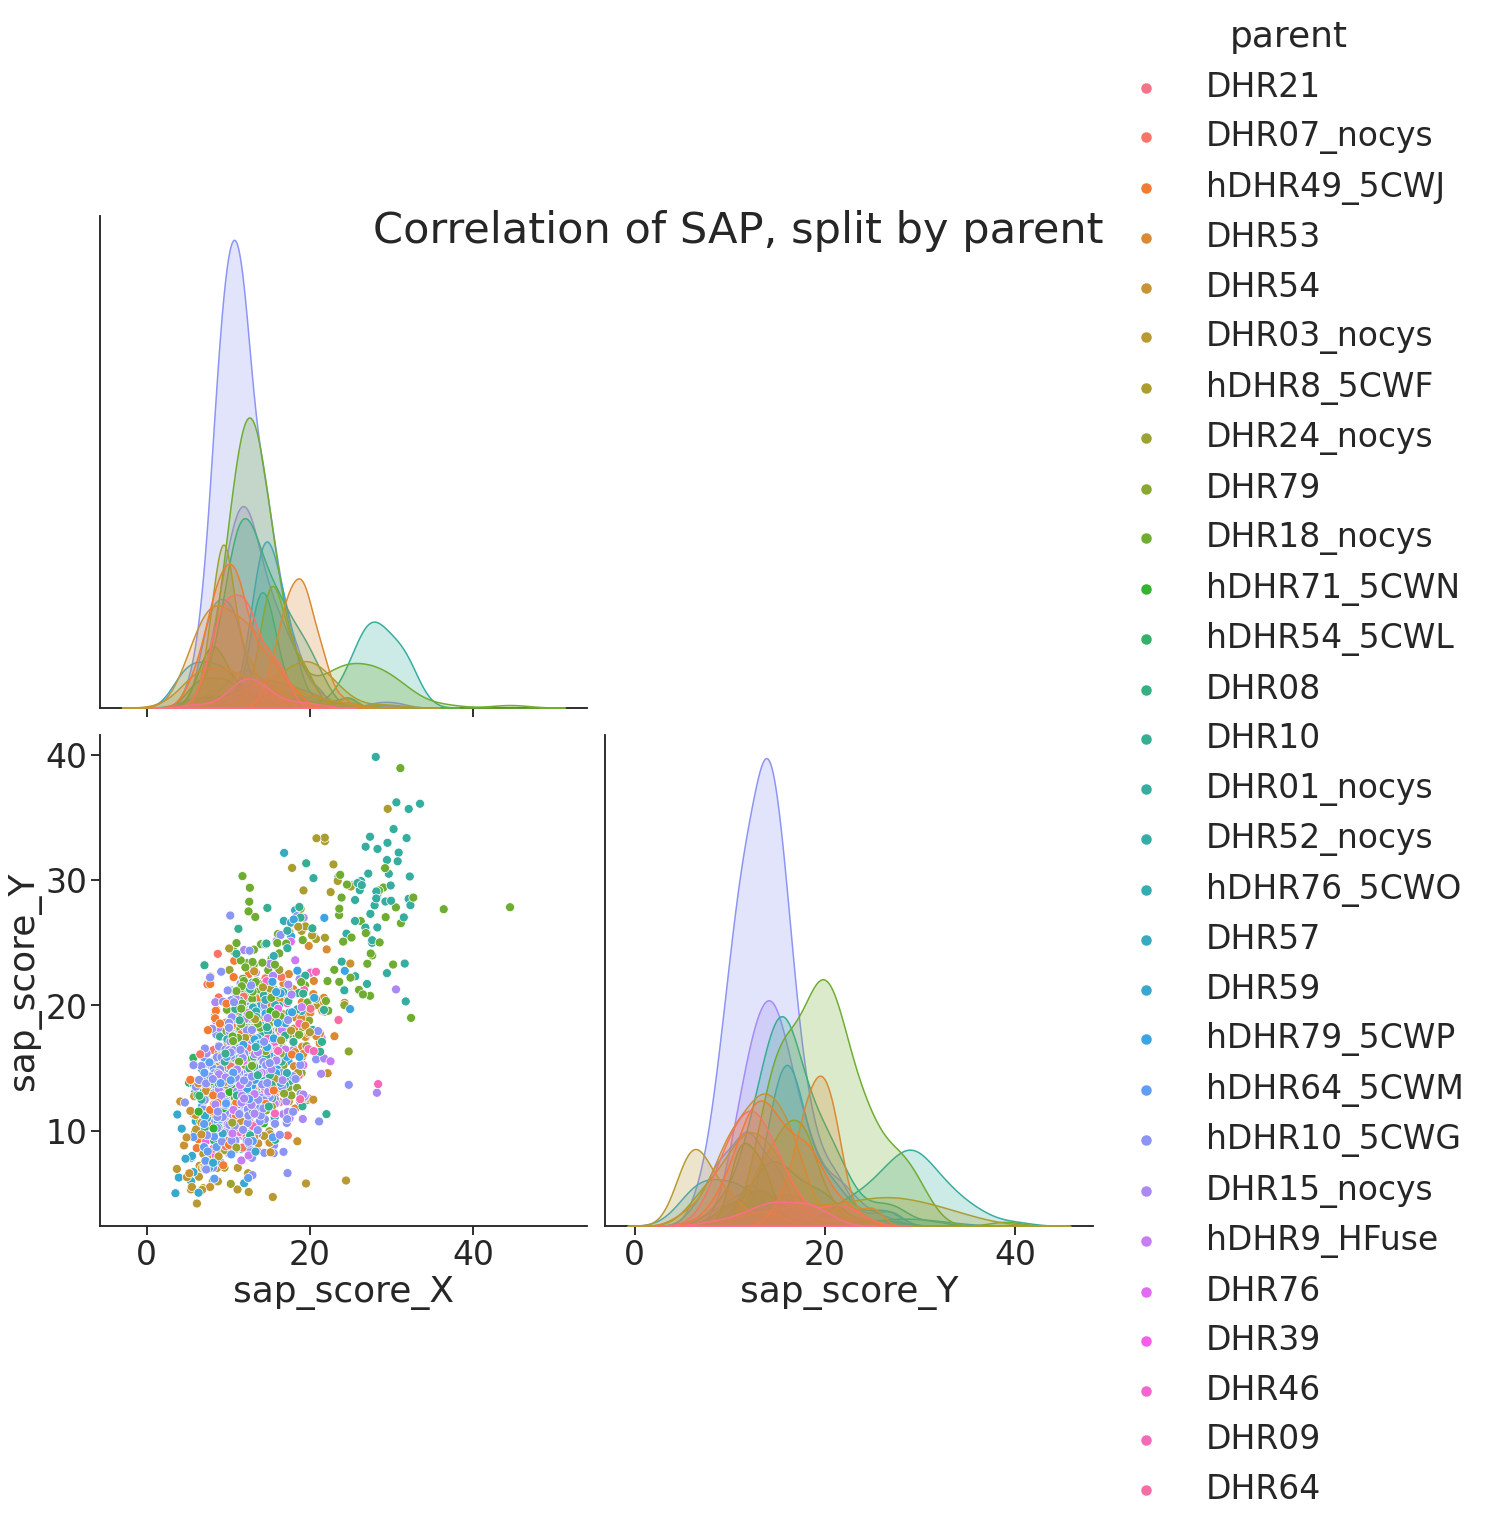

In [5]:
sns.set(
    context="talk",
    font_scale=2, # make the font larger; default is pretty small
    style="ticks", # make the background white with black lines
    palette="colorblind" # a color palette that is colorblind friendly!
)

sap_subset = scores_df[
    [
        "sap_score_X",
        "sap_score_Y",
        "parent",
    ]
]

ax = sns.pairplot(data=sap_subset, hue="parent", corner=True, height=8)
plt.suptitle("Correlation of SAP, split by parent")
sns.despine()
plt.savefig("figs/05_correlations_sap_split_by_parent.png")

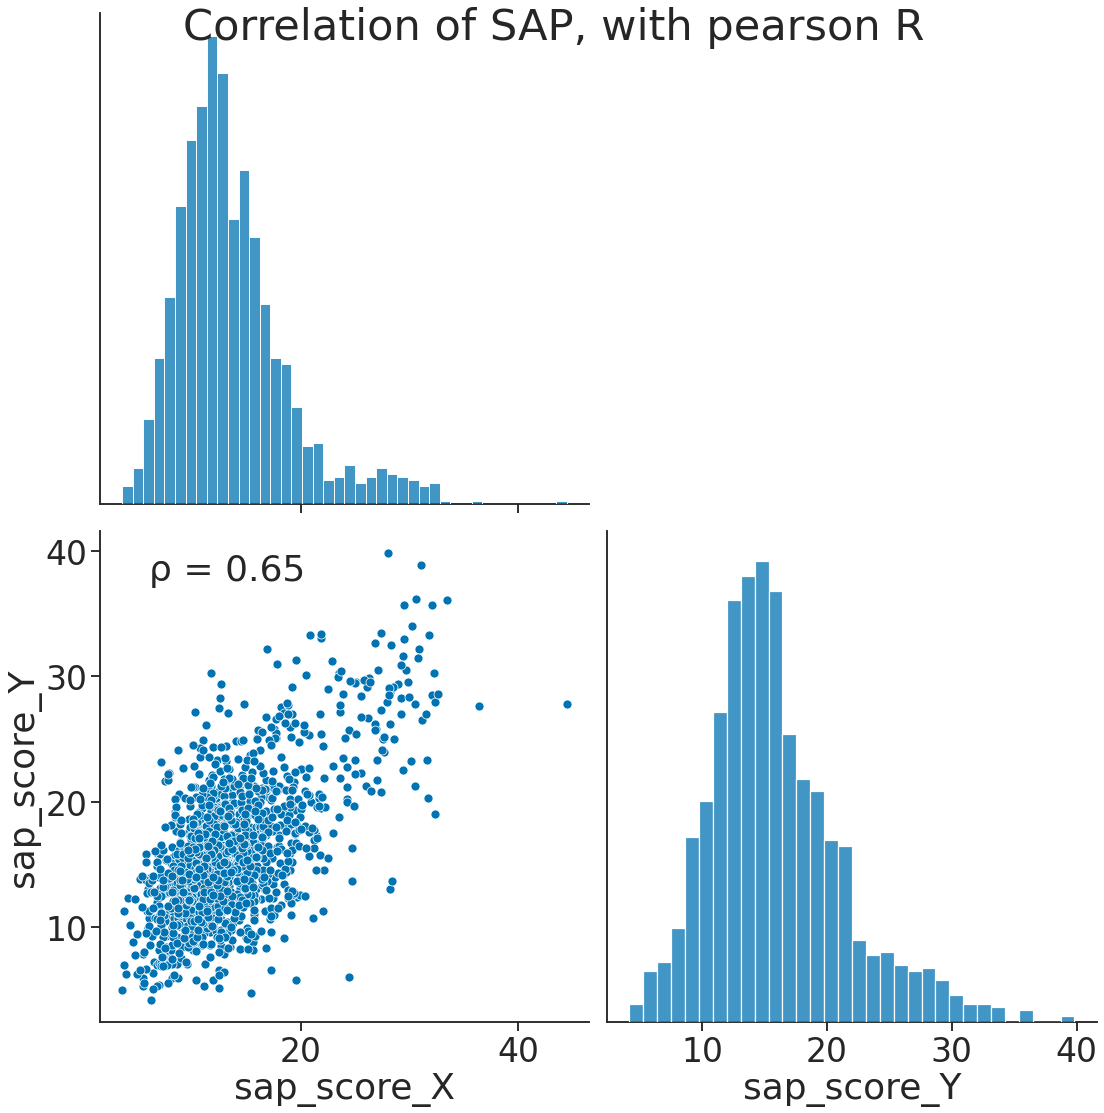

In [6]:
def rho(x, y, ax=None, **kwargs):
    """Plot the correlation coefficient in the top left hand corner of a plot.
    https://stackoverflow.com/questions/50832204/show-correlation-values-in-pairplot-using-seaborn-in-python/50835066
    """
    import scipy
    r, _ = scipy.stats.pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ) 
    rho = "\u03C1"
    ax.annotate(f"{rho} = {r:.2f}", xy=(.1, .9), xycoords=ax.transAxes)

ax = sns.pairplot(data=sap_subset, corner=True, height=8)
ax.map_lower(rho)
plt.suptitle("Correlation of SAP, with pearson R")
sns.despine()
plt.savefig("figs/05_correlations_SAP_pearson.png")

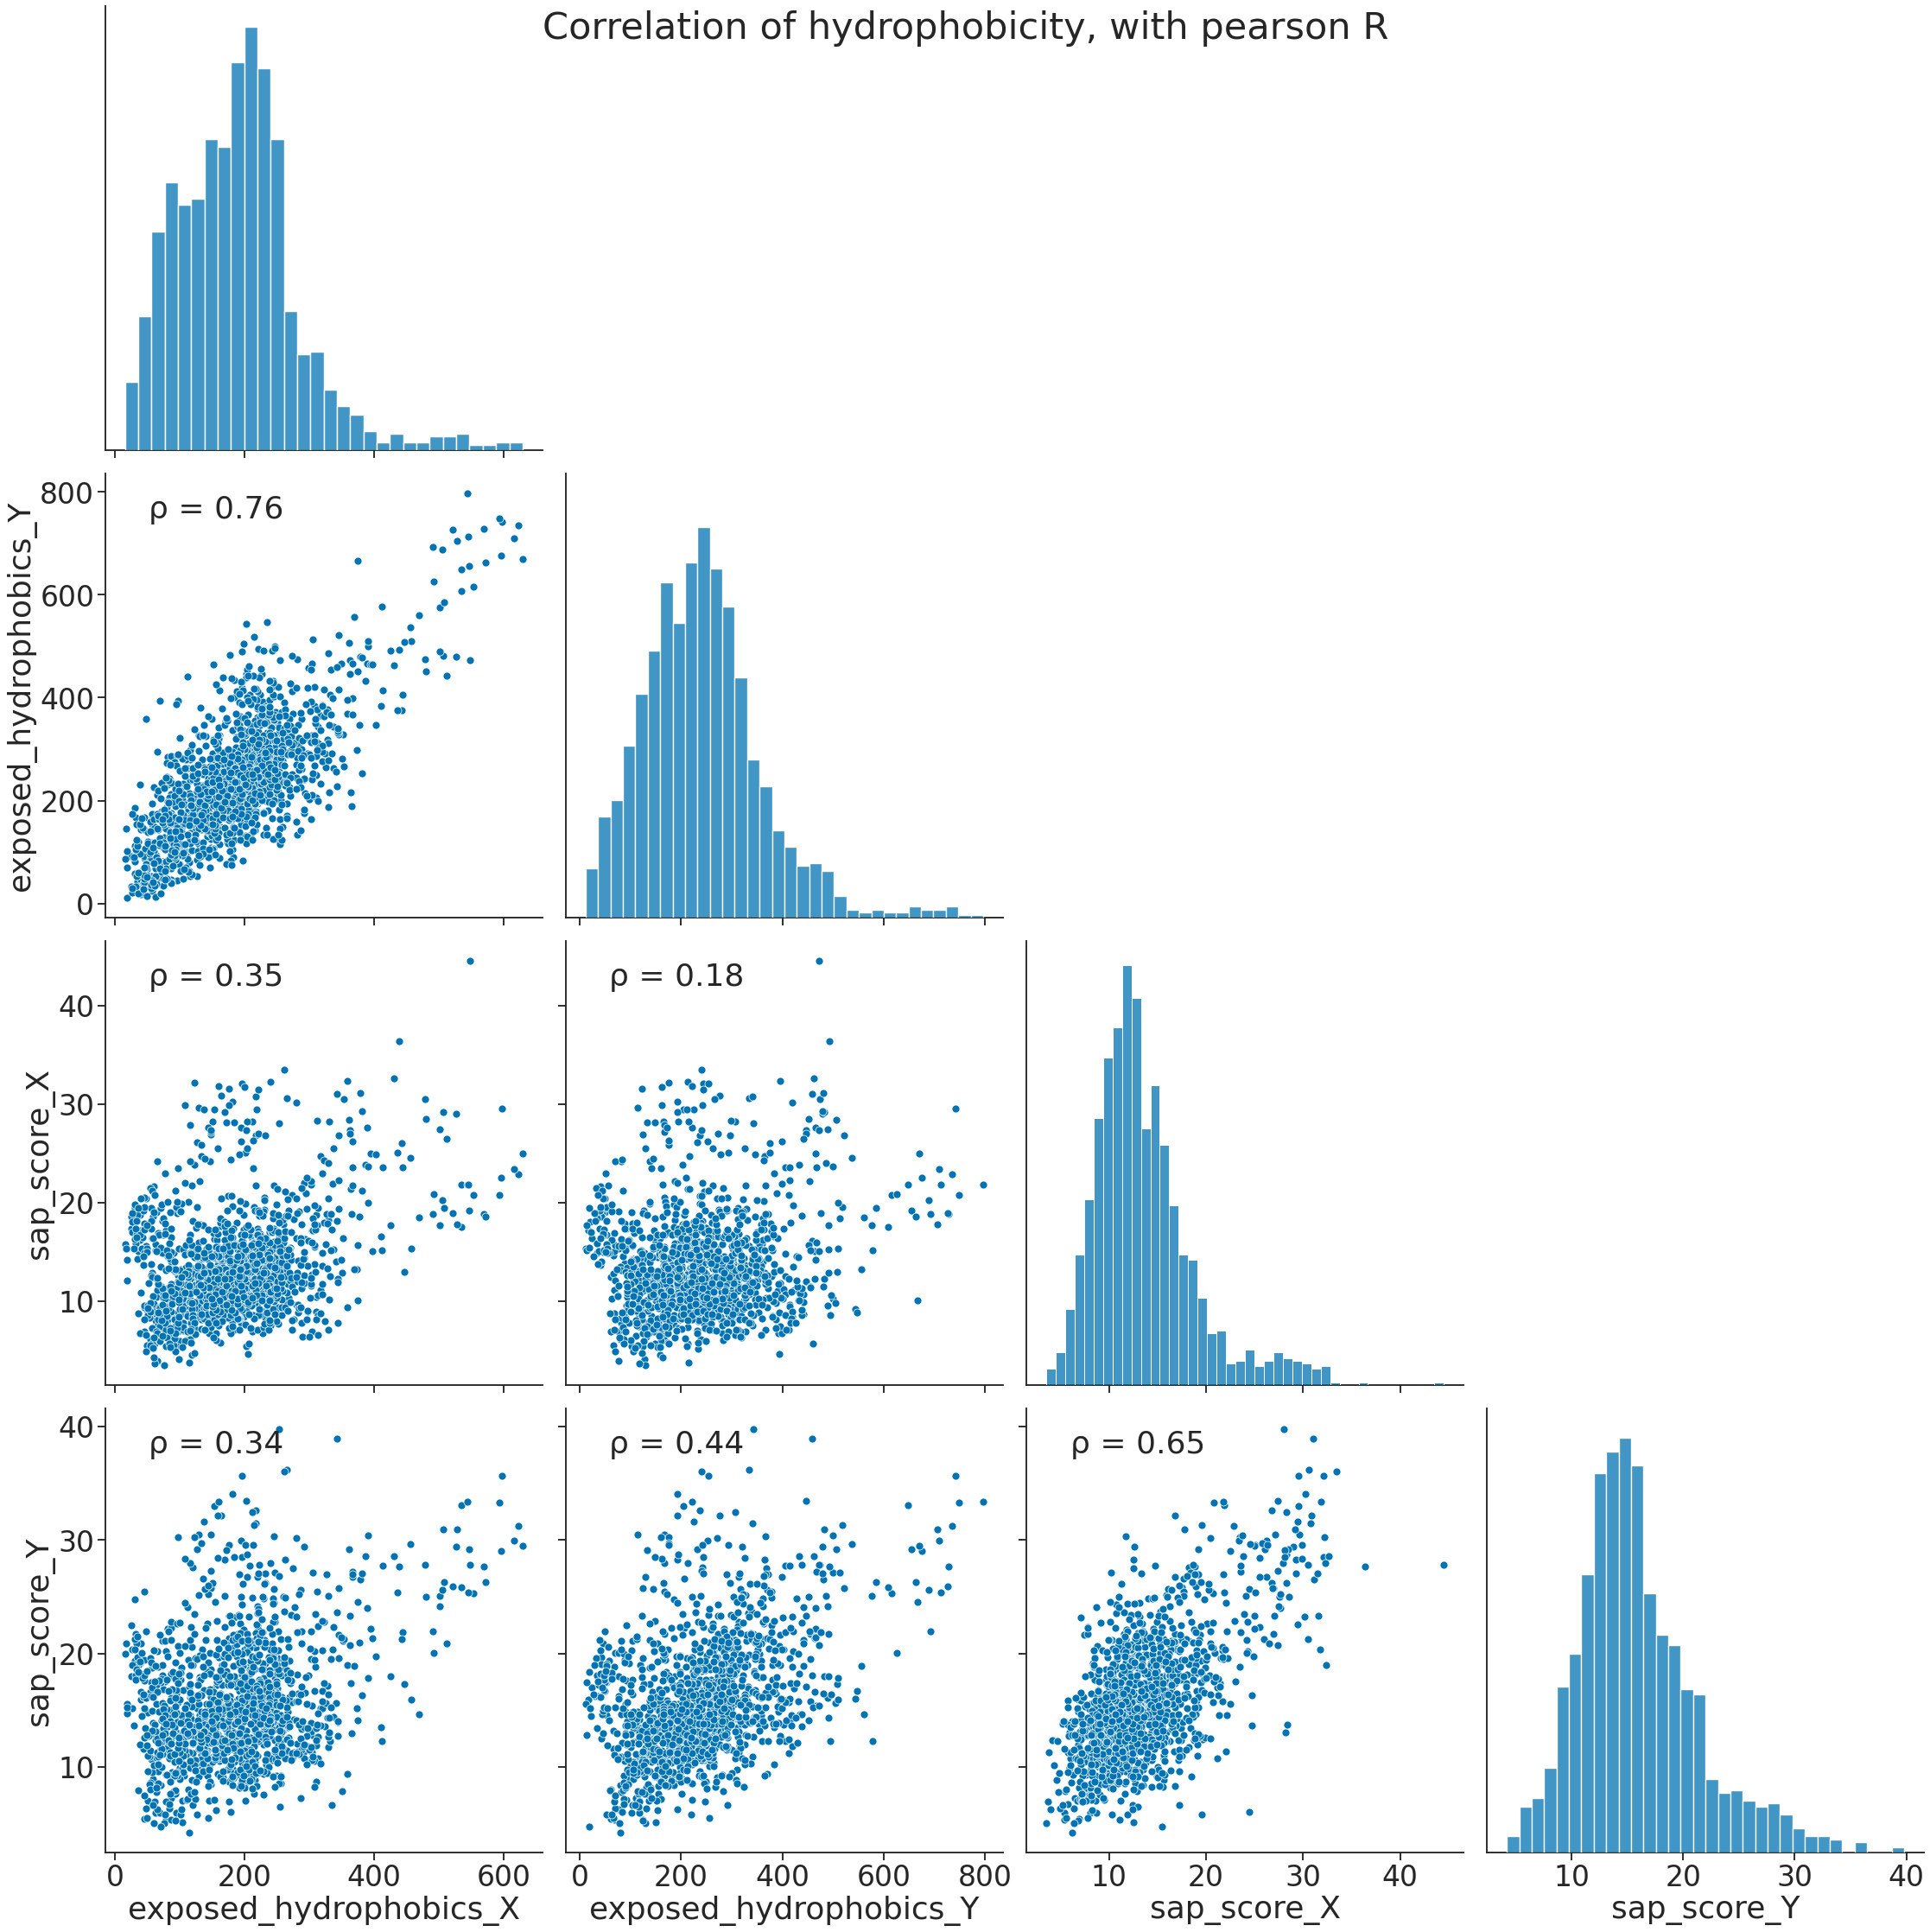

In [7]:
sap_subset = scores_df[
    [
        "exposed_hydrophobics_X",
        "exposed_hydrophobics_Y",
        "sap_score_X",
        "sap_score_Y",
        "parent",
    ]
]

ax = sns.pairplot(data=sap_subset, hue="parent", corner=True, height=8)
plt.suptitle("Correlation of hydrophobicity, split by parent")
sns.despine()
plt.savefig("figs/05_correlations_hydrophobicity_split_by_parent.png")

plt.close()

ax = sns.pairplot(data=sap_subset, corner=True, height=8)
ax.map_lower(rho)
plt.suptitle("Correlation of hydrophobicity, with pearson R")
sns.despine()
plt.savefig("figs/05_correlations_hydrophobicity_pearson.png")

In [ ]:
frag_subset = scores_df[
    [
        "geometry_X",
        "geometry_Y",
        "mismatch_probability_X",
        "mismatch_probability_Y",
        "wnm_all_X",
        "wnm_all_Y",
        "wnm_hlx_X",
        "wnm_hlx_Y",
        "parent",
    ]
]

ax = sns.pairplot(data=frag_subset, hue="parent", corner=True, height=8)
plt.suptitle("Correlation of fragment metrics, split by parent")
sns.despine()
plt.savefig("figs/05_correlations_frag_split_by_parent.png")

plt.close()

ax = sns.pairplot(data=frag_subset, corner=True, height=8)
ax.map_lower(rho)
plt.suptitle("Correlation of fragment metrics, with pearson R")
sns.despine()
plt.savefig("figs/05_correlations_frag_pearson.png")

In [9]:
output_path = os.path.join(os.getcwd(), "05_two_state_n2_sap")
scores = os.path.join(output_path, "scores.json")
scores_df = read_scorefile(scores)

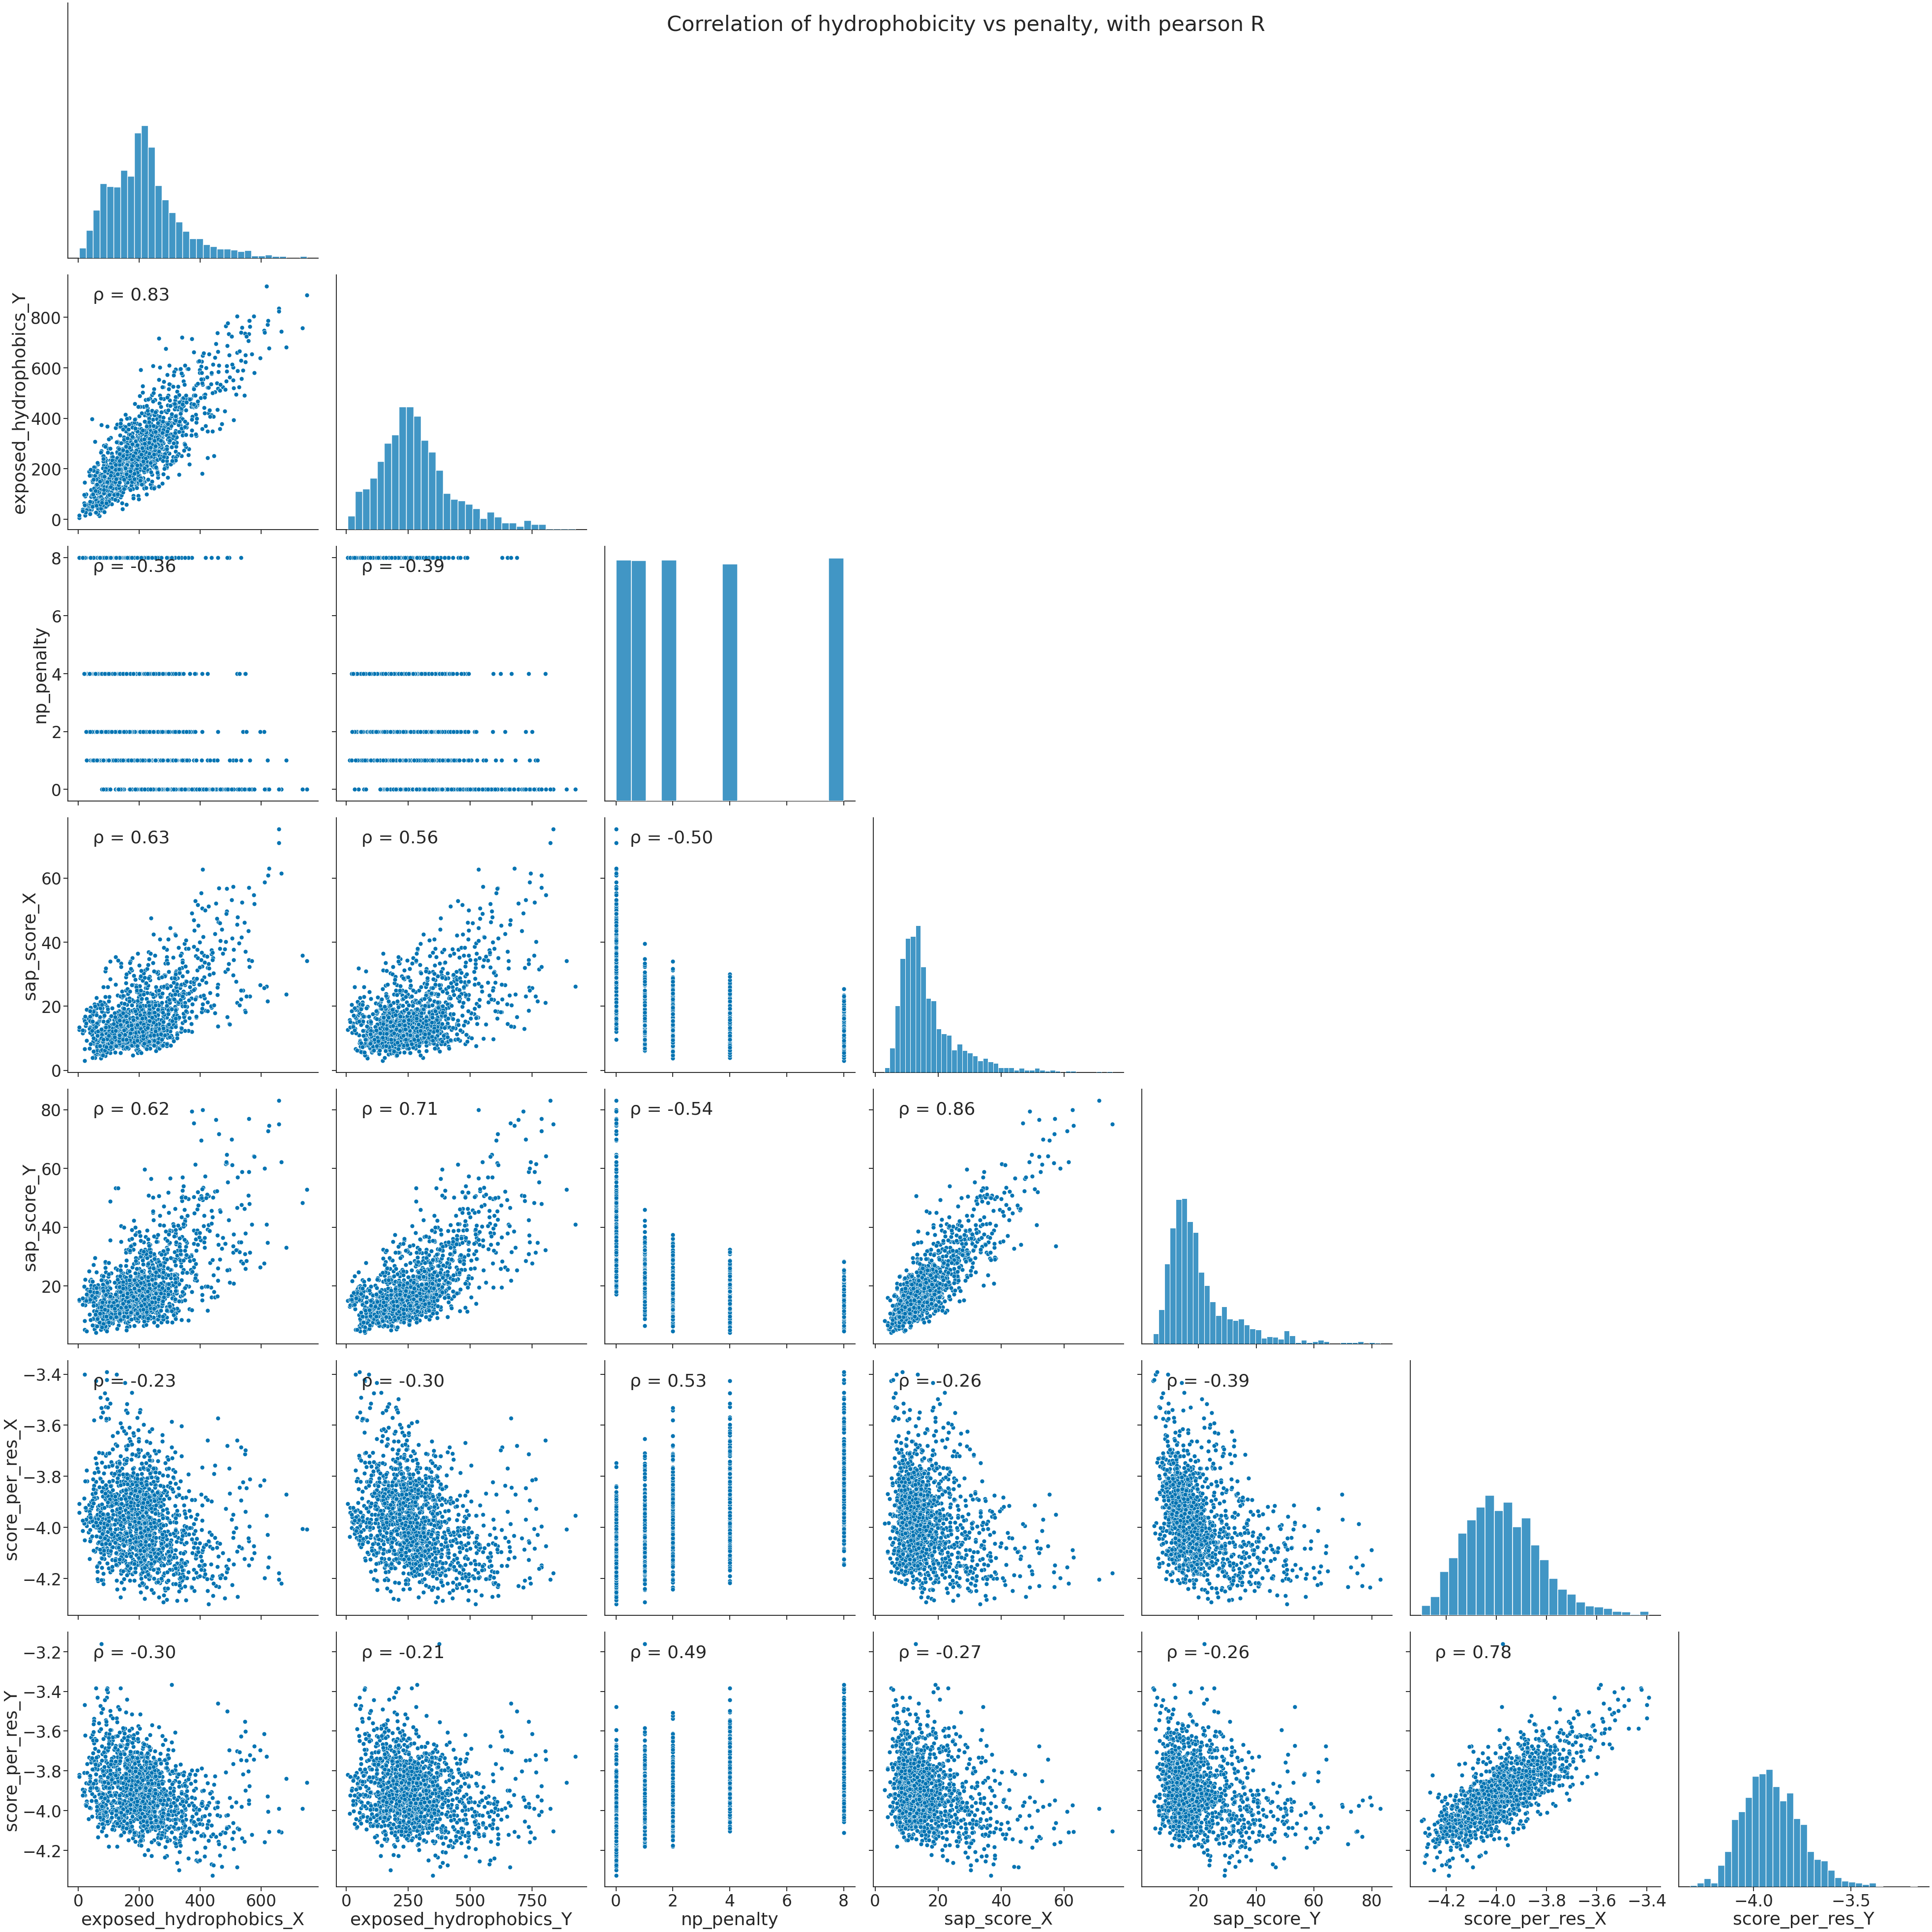

In [11]:
sap_subset = scores_df[
    [
        "exposed_hydrophobics_X",
        "exposed_hydrophobics_Y",
        "np_penalty",
        "sap_score_X",
        "sap_score_Y",
        "score_per_res_X",
        "score_per_res_Y",
        "parent",
    ]
]

ax = sns.pairplot(data=sap_subset, hue="parent", corner=True, height=8)
plt.suptitle("Correlation of hydrophobicity vs penalty, split by parent")
sns.despine()
plt.savefig("figs/05_correlations_hydrophobicity_penalty_split_by_parent.png")

plt.close()

ax = sns.pairplot(data=sap_subset, corner=True, height=8)
ax.map_lower(rho)
plt.suptitle("Correlation of hydrophobicity vs penalty, with pearson R")
sns.despine()
plt.savefig("figs/05_correlations_hydrophobicity_penalty_pearson.png")